In [28]:
import os
import folium
import shapely
import shapely.wkt
import numpy as np
import xarray as xr
import hvplot.xarray
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
fig_dir = '/Users/coreyscher/Documents/GitHub/arset/arset/figures'

In [3]:
insar_path = '/Users/coreyscher/Documents/GitHub/arset/arset/data/insar'

pre_event = os.path.join(insar_path, 
                         'S1AA_20160610T033416_20160821T033420_VVP072_INT40_G_ueF_3D10',
                         'S1AA_20160610T033416_20160821T033420_VVP072_INT40_G_ueF_3D10_corr.tif')

event = os.path.join(insar_path, 
                         'S1AB_20160821T033420_20161026T033341_VVP066_INT40_G_ueF_C851',
                         'S1AB_20160821T033420_20161026T033341_VVP066_INT40_G_ueF_C851_corr.tif')

In [95]:
pre = xr.open_dataset(pre_event, engine="rasterio")
post = xr.open_dataset(event, engine="rasterio")

In [92]:
#Define and area of interest as WKT over Aleppo, Syria
aoi = shapely.wkt.loads("POLYGON((37.0072 36.091, \
                        37.3326 36.091,37.3326 36.3183, \
                        37.0072 36.3183,37.0072 36.091))")
gs = gpd.GeoSeries(aoi, crs = 'EPSG:4326').to_crs(pre.rio.crs)
# Translate to geojson for quick addition to interactrive Folium maps
geo_j = folium.GeoJson(data=gs.to_json())

CRS.from_epsg(32637)

In [97]:
#pre_proj = pre.rio.reproject("EPSG:4326")
#post_proj = post.rio.reproject("EPSG:4326")

pre_proj = pre.rio.clip(gs)
post_proj = post.rio.clip(gs)


In [100]:
aligned = xr.align(pre_proj, post_proj)

In [105]:
post_proj.mean()

<xarray.Dataset>
Dimensions:      ()
Coordinates:
    spatial_ref  int64 0
Data variables:
    band_data    float32 0.8454

In [106]:
pre_proj.mean()

<xarray.Dataset>
Dimensions:      ()
Coordinates:
    spatial_ref  int64 0
Data variables:
    band_data    float32 0.7902

In [107]:
# Calculate the change in coherence relative to the pre-conflict 

dif = (post_proj['band_data'] - pre_proj['band_data'])/pre_proj['band_data']

In [8]:
mask = pre_proj['band_data'] < 0.9

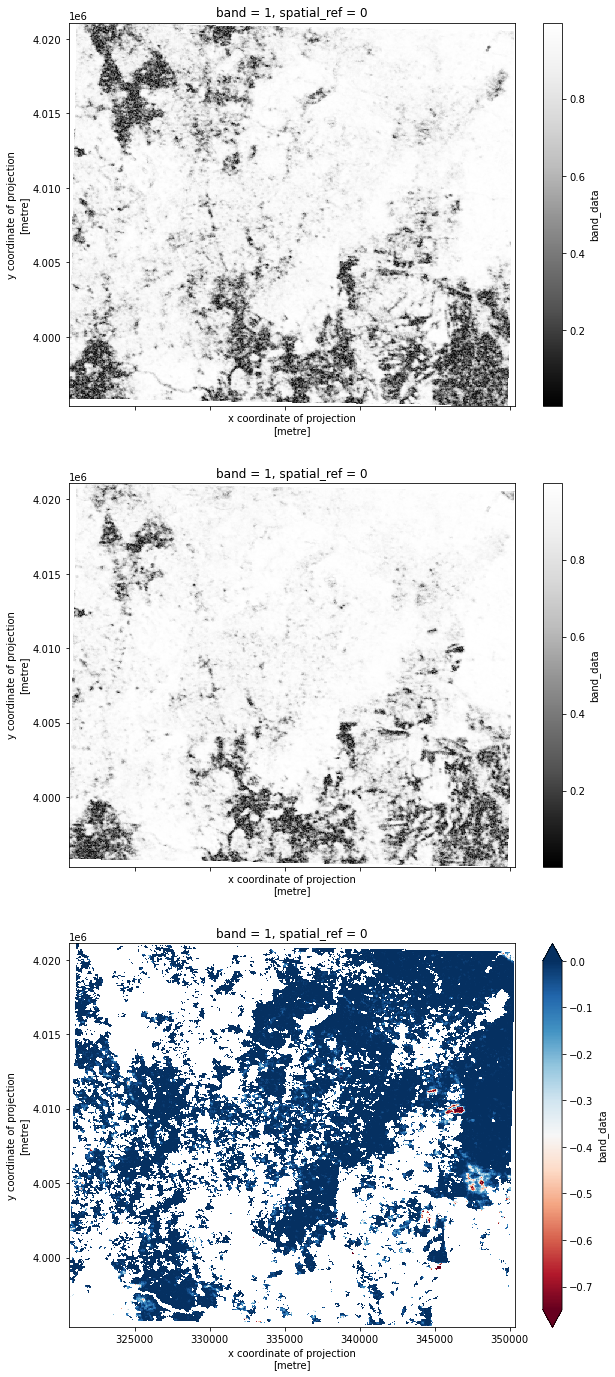

In [119]:
fig, ax = plt.subplots(3,1, figsize=(10,24), sharex=True)

mask = pre_proj['band_data'] < 0.8

pre_proj['band_data'].plot(cmap='Greys_r', ax = ax[0])
post_proj['band_data'].plot(cmap='Greys_r', ax = ax[1])

dif.where(pre_proj > 0.9)['band_data'].plot(cmap='RdBu', ax = ax[2], vmin = -.75, vmax = 0)

#dif.plot(cmap='RdBu', ax = ax[2], vmin = -.75, vmax = 0)
#dif_mask.where(dif_mask ==0).plot(cmap='RdBu', ax = ax[2], vmin = -.75, vmax = 0)

# for a in ax:
#     a.set_xlim(37.08, 37.22)
#     a.set_ylim(36.13, 36.26)
    
#plt.savefig(os.path.join(fig_dir, 'example_aleppo.png'), dpi=300, facecolor='white')

In [125]:
dif_plot = dif.where(pre_proj > 0.9)['band_data'].hvplot.quadmesh(cmap='RdBu',
                                                                  ax = ax[2], 
                                                                  vmin = -.75, 
                                                                  vmax = 0, 
                                                                  frame_width = 500,
                                                                 frame_height = 500)




In [126]:
hvplot.save(dif_plot, os.path.join(fig_dir, 'test_interactive_plot.html'))